# **Implementing CycleGAN for Image-to-Image Translation**
### Elsun Nabatov

## **Introduction**

In this segment of deep learning coursework, I embarked on an exciting journey to explore the capabilities of CycleGAN, a cutting-edge architecture renowned for its impressive image-to-image translation results. Objective was to apply this model to distinct datasets, demonstrating our proficiency in adapting existing models to diverse types of data. The essence of CycleGAN lies in its ability to perform unpaired image-to-image translation, allowing us to transform images from one domain to another without the need for one-to-one mapping between the source and target domain images.

In [1]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513
Receiving objects: 100% (2513/2513), 8.20 MiB | 2.95 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [1]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [4]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


### **Data Preparation and Processing**

Our dataset comprised images from four distinct categories: cats, dogs, aligned celebrity faces, and cropped UTK Faces. To accommodate our model's requirements, I extracted these images from zip files, organizing them into appropriate directories. This organization facilitated easier access and manipulation during the preprocessing phase.

In [6]:
import os
import zipfile
import shutil

def unzip_file(zip_path, extract_to, ignore_outer_folder=False):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        if ignore_outer_folder:
            # Extracting only the contents of a specific folder inside the zip
            
            for member in zip_ref.namelist():
                # Checking if the member is inside the desired folder and extract only those
                if member.startswith("utkcropped/"):
                    target_path = os.path.join(extract_to, os.path.relpath(member, "utkcropped/"))
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        shutil.copyfileobj(source, target)
        else:
            zip_ref.extractall(extract_to)

# 'cycle_data' is in the current working directory
data_dir = './cycle_data'
extract_to_dir = './unzipped_data'

# Creating the directory where to extract files
if not os.path.exists(extract_to_dir):
    os.makedirs(extract_to_dir)

# List of zip files to extract
zip_files = ["cats.zip", "dogs.zip", "face_align_celeba.zip", "UTK Face Cropped.zip"]

for zip_file in zip_files:
    zip_path = os.path.join(data_dir, zip_file)
    if zip_file == "UTK Face Cropped.zip":
        unzip_file(zip_path, extract_to_dir, ignore_outer_folder=True)
    else:
        unzip_file(zip_path, extract_to_dir)


### **Image Preprocessing**

I initiated by processing dataset, specifically images of cats and dogs, to prepare them for training. Using PIL library, I resized all images to a uniform dimension of 64x64 pixels. This standardization is crucial for the consistency and efficiency of neural network model.

After resizing, I split the dataset into training and test sets with an 80-20 ratio using the `train_test_split` method from sklearn, ensuring a balanced approach to training and evaluating the model. The processed images were then saved into 'trainB' and 'testB' directories, setting the stage for the model's training and testing phases.

In [8]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os

def process_images(source_folders, target_dir, train_size=0.8):
    images = []
    for folder in source_folders:
        folder_path = Path('unzipped_data') / folder
        for img_file in os.listdir(folder_path):
            img_path = folder_path / img_file
            try:
                # Open the image and resize it
                with Image.open(img_path) as img:
                    img = img.resize((64, 64))
                    images.append((img, img_file))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    # Split the dataset
    train, test = train_test_split(images, train_size=train_size, random_state=42)
    
    # Function to save images
    def save_images(data, folder_name):
        target_folder = Path(target_dir) / folder_name
        target_folder.mkdir(parents=True, exist_ok=True)
        for img, img_name in data:
            img.save(target_folder / img_name)
    
    # Save the datasets
    save_images(train, 'trainB')
    save_images(test, 'testB')

process_images(['cats', 'dogs'], 'processed_data')

I further processed images from the img_face_celeba and UTKFace datasets, focusing on human faces. Resized each image to 64x64 pixels for consistency. To ensure diversity while managing dataset size, randomly selected up to 5000 images per dataset, balancing the variety of human faces for the model.

Then divided these images into training and test sets with an 80-20 split, preparing them for the CycleGAN training and testing phases. The processed images were saved in 'trainA' and 'testA' directories, which are essential for the model to learn transformations across different domains effectively.

In [11]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import random

def resize_and_sample_images(source_folders, target_dir, sample_size=5000, train_size=0.8):
    all_images = []

    for folder in source_folders:
        folder_path = Path('unzipped_data') / folder
        images = []
        for img_file in os.listdir(folder_path):
            img_path = folder_path / img_file
            try:
                with Image.open(img_path) as img:
                    img_resized = img.resize((64, 64))
                    images.append((img_resized, img_file))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        # Randomly sample images
        sampled_images = random.sample(images, min(sample_size, len(images)))
        all_images.extend(sampled_images)

    # Split the dataset
    train, test = train_test_split(all_images, train_size=train_size, random_state=42)

    # Function to save images
    def save_images(data, folder_name):
        target_folder = Path(target_dir) / folder_name
        target_folder.mkdir(parents=True, exist_ok=True)
        for img, img_name in data:
            img.save(target_folder / img_name)
    
    # Save the datasets
    save_images(train, 'trainA')
    save_images(test, 'testA')

resize_and_sample_images(['img_align_celeba', 'utkcropped'], 'processed_data')

To validate the balance of our dataset for the CycleGAN project, I developed a script to count images in 'processed_data' and verify the training-testing split. Utilizing Pathlib for directory traversal and image counting, it calculates the proportion of training images, aiming for an 80-20 split. The script confirms dataset integrity by reporting image counts and training data proportion, essential for a balanced training approach.

In [12]:
from pathlib import Path

def count_images_and_verify_proportion(base_dir='processed_data'):
    folders = ['trainA', 'testA', 'trainB', 'testB']
    counts = {folder: 0 for folder in folders}

    # Count the images in each folder
    for folder in folders:
        folder_path = Path(base_dir) / folder
        counts[folder] = len(list(folder_path.glob('*.jpg'))) + len(list(folder_path.glob('*.png')))

    total_images = sum(counts.values())
    train_images = counts['trainA'] + counts['trainB']
    test_images = counts['testA'] + counts['testB']

    # Calculate the proportion of training images
    train_proportion = (train_images / total_images) * 100 if total_images > 0 else 0

    print(f"Image Counts:\nTrainA: {counts['trainA']}, TestA: {counts['testA']}, TrainB: {counts['trainB']}, TestB: {counts['testB']}")
    print(f"Total images: {total_images}")
    print(f"Training images proportion: {train_proportion:.2f}% (Approximately 80% is expected)")

    # Verify if the proportion is approximately 80%
    if 79 <= train_proportion <= 81:
        print("The proportion of training images is within the expected range.")
    else:
        print("The proportion of training images is not within the expected range.")

count_images_and_verify_proportion()

Image Counts:
TrainA: 8000, TestA: 2000, TrainB: 16631, TestB: 4158
Total images: 30789
Training images proportion: 80.00% (Approximately 80% is expected)
The proportion of training images is within the expected range.


### **Reconfiguration size of testB and trainB**

Noticing an imbalance in the TrainB and TestB image counts, I decided to reconfigure the dataset to ensure a more balanced distribution, aiming for an 80-20 split between training and testing sets. To achieve this, I crafted a script to clear existing directories and redistribute images of cats and dogs, targeting a total of 10,000 images split according to the desired proportion. The script dynamically calculates the number of images needed from each category, samples them, and then evenly splits them into training and testing sets, correcting the previous imbalance and aligning the dataset composition with our training requirements.

In [13]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

def clear_directory(path):
    """
    Clears all files and folders in the specified directory.
    """
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        else:  
            shutil.rmtree(item_path)

def adjust_train_test_b_v2(proportion_train=0.8):
    # Define paths
    cats_path = Path('unzipped_data/cats')
    dogs_path = Path('unzipped_data/dogs')
    train_b_path = Path('processed_data/trainB')
    test_b_path = Path('processed_data/testB')
    
    # Ensure target directories exist or clear them
    for path in [train_b_path, test_b_path]:
        if path.exists():
            clear_directory(path)
        else:
            path.mkdir(parents=True, exist_ok=True)

    # List and combine all cat and dog images
    cat_images = [f for f in os.listdir(cats_path) if os.path.isfile(os.path.join(cats_path, f))]
    dog_images = [f for f in os.listdir(dogs_path) if os.path.isfile(os.path.join(dogs_path, f))]

    # Determining the proportion of images to sample from each category
    total_images_needed = 10000  # 8000 for train and 2000 for test
    cats_proportion = len(cat_images) / (len(cat_images) + len(dog_images))
    cats_needed = round(total_images_needed * cats_proportion)
    dogs_needed = total_images_needed - cats_needed

    # Sample images according to calculated proportions
    sampled_cat_images = random.sample(cat_images, cats_needed)
    sampled_dog_images = random.sample(dog_images, dogs_needed)

    # Combine, shuffle, and split
    combined_images = [(img, 'cat') for img in sampled_cat_images] + [(img, 'dog') for img in sampled_dog_images]
    random.shuffle(combined_images)
    train_images, test_images = train_test_split(combined_images, train_size=proportion_train, random_state=42)

    # Function to save images
    def save_images(data, target_folder):
        for img_name, category in data:
            src_path = cats_path if category == 'cat' else dogs_path
            dest_path = target_folder / img_name
            shutil.copy(src_path / img_name, dest_path)

    # Save the datasets
    save_images(train_images, train_b_path)
    save_images(test_images, test_b_path)

# Executing the function to adjust TrainB and TestB directories
adjust_train_test_b_v2()

### **Reverification trainB and testB size**

After adjusting dataset, a recheck confirmed that TrainB and TestB now contain 8,000 and 2,000 images respectively, achieving a balanced 80-20 split across all datasets. This ensures our CycleGAN project is set on a solid foundation, with an evenly distributed dataset ready for effective model training and testing.

In [14]:
from pathlib import Path

def count_images_and_verify_proportion(base_dir='processed_data'):
    folders = ['trainA', 'testA', 'trainB', 'testB']
    counts = {folder: 0 for folder in folders}

    # Count the images in each folder
    for folder in folders:
        folder_path = Path(base_dir) / folder
        counts[folder] = len(list(folder_path.glob('*.jpg'))) + len(list(folder_path.glob('*.png')))

    total_images = sum(counts.values())
    train_images = counts['trainA'] + counts['trainB']
    test_images = counts['testA'] + counts['testB']

    # Calculate the proportion of training images
    train_proportion = (train_images / total_images) * 100 if total_images > 0 else 0

    print(f"Image Counts:\nTrainA: {counts['trainA']}, TestA: {counts['testA']}, TrainB: {counts['trainB']}, TestB: {counts['testB']}")
    print(f"Total images: {total_images}")
    print(f"Training images proportion: {train_proportion:.2f}% (Approximately 80% is expected)")

    # Verify if the proportion is approximately 80%
    if 79 <= train_proportion <= 81:
        print("The proportion of training images is within the expected range.")
    else:
        print("The proportion of training images is not within the expected range.")

count_images_and_verify_proportion()

Image Counts:
TrainA: 8000, TestA: 2000, TrainB: 8000, TestB: 2000
Total images: 20000
Training images proportion: 80.00% (Approximately 80% is expected)
The proportion of training images is within the expected range.


### **Training CycleGAN for Animal Image Creation**

I started the CycleGAN model's training using the train.py script, aiming to transform images into animal styles, focusing on cats and dogs. I named this experiment 'animalcreation' and set it to run through 20 epochs - 10 for initial learning and another 10 for decay, to refine the model's ability to generate realistic transformations.

In [16]:
!python3 train.py --dataroot ./processed_data --name animalcreation --model cycle_gan --display_id -1 --n_epochs=10 --n_epochs_decay=10

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./processed_data              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

The training log highlights a consistent improvement in discriminator and generator losses, alongside reductions in cycle consistency (cycle_A and cycle_B) and identity losses (idt_A and idt_B) across 200 epochs of a CycleGAN model. Notably, generator losses for both domains A and B decreased by approximately 0.264 and 0.235, respectively, while cycle consistency losses improved by approximately 0.087 and 0.079. These reductions signify substantial advancements in the model's ability to generate realistic images and maintain cycle consistency between domains, indicating effective learning and optimization of the loss functions employed throughout training.

### Trained Model saving

The file latest_net_G_A.pth has been successfully copied to latest_net_G.pth within the animalcreation checkpoints directory.

In [18]:
cp ./checkpoints/animalcreation/latest_net_G_A.pth ./checkpoints/animalcreation/latest_net_G.pth

### Testing with Pictures

In [8]:
!python3 test.py --dataroot ./processed_data/testA --name human --model test --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./processed_data/testA        	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

### **Visualize image from test folder**

The model has converted the features of a human face into an animal-like appearance, which can be observed in the altered facial structure and the addition of what appears to be fur and animal ears.

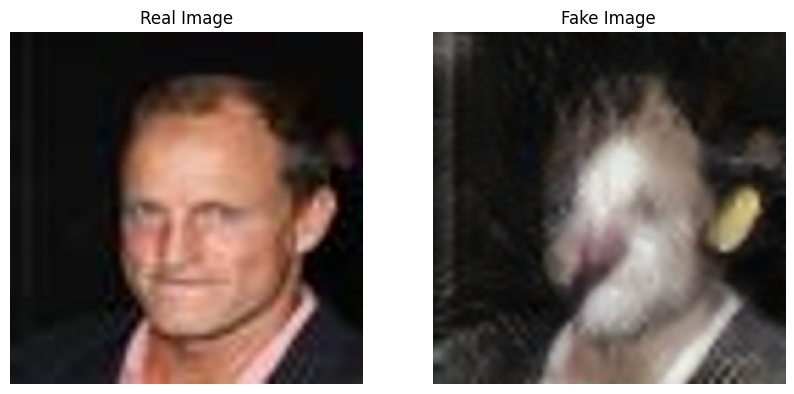

In [31]:
import matplotlib.pyplot as plt

# Load the images
img_real = plt.imread('./results/animalcreation/test_latest/images/002763_real.png')
img_fake = plt.imread('./results/animalcreation/test_latest/images/002763_fake.png')

# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))  # figure size

# Plot the real image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img_real)
plt.title('Real Image')
plt.axis('off')  # Hiding the axis

# Plot the fake image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img_fake)
plt.title('Fake Image')
plt.axis('off')  # Hiding the axis

plt.show()

### **Test with my pictures**

In [35]:
!python3 test.py --dataroot ./resized_profimages/ --name animalcreation --model test --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./resized_profimages/         	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

### Visualize my picture and Professor

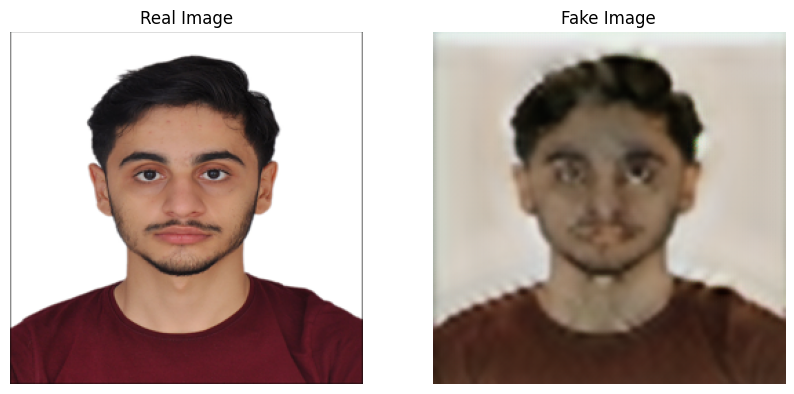

In [33]:
import matplotlib.pyplot as plt

# Load the images
img_real = plt.imread('./results/animalcreation/test_latest/images/Vesikalık Fotoğraf_real.png')
img_fake = plt.imread('./results/animalcreation/test_latest/images/Vesikalık Fotoğraf_fake.png')

# Creating a figure to hold the subplots
plt.figure(figsize=(10, 5))  # figure size

# Plot the real image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img_real)
plt.title('Real Image')
plt.axis('off')  # Hiding the axis

# Plot the fake image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img_fake)
plt.title('Fake Image')
plt.axis('off')  # Hiding the axis

plt.show()

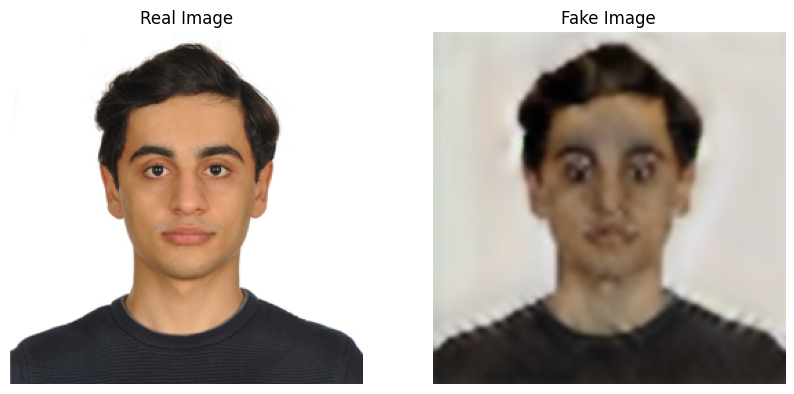

In [32]:
import matplotlib.pyplot as plt

# Load the images
img_real = plt.imread('./results/animalcreation/test_latest/images/Elsun Nabatov_real.png')
img_fake = plt.imread('./results/animalcreation/test_latest/images/Elsun Nabatov_fake.png')

# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))  # figure size

# Plot the real image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img_real)
plt.title('Real Image')
plt.axis('off')  # Hiding the axis

# Plot the fake image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img_fake)
plt.title('Fake Image')
plt.axis('off')  # Hiding the axis

plt.show()

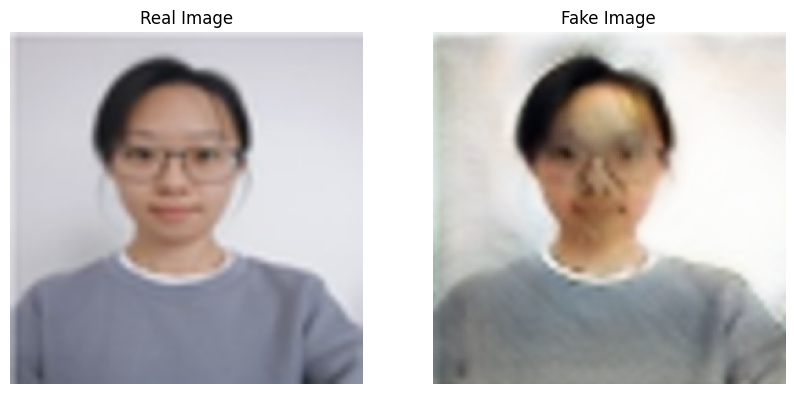

In [37]:
import matplotlib.pyplot as plt

# Load the images
img_real = plt.imread('./results/animalcreation/test_latest/images/Tong_real.png')
img_fake = plt.imread('./results/animalcreation/test_latest/images/Tong_fake.png')

# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))

# Plot the real image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img_real)
plt.title('Real Image')
plt.axis('off')  # Hiding the axis

# Plot the fake image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img_fake)
plt.title('Fake Image')
plt.axis('off')  # Hiding the axis

plt.show()

### **Resizing image for demonstration**

In [34]:
from PIL import Image
import os

# Directory for the images to be resized
source_dir = '/home/elsun/new_cyclegan/pytorch-CycleGAN-and-pix2pix/profimages'

# Directory where resized images will be saved
resized_dir = '/home/elsun/new_cyclegan/pytorch-CycleGAN-and-pix2pix/resized_profimages'
os.makedirs(resized_dir, exist_ok=True)

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for common image file extensions
        # Path to the current file
        file_path = os.path.join(source_dir, filename)
        
        # Open the image
        img = Image.open(file_path)
        
        # Resize the image
        img_resized = img.resize((64, 64), Image.ANTIALIAS)
        
        # Path to save the resized image
        resized_file_path = os.path.join(resized_dir, filename)
        
        # Save the resized image
        img_resized.save(resized_file_path)

print("All images have been resized and saved.")

All images have been resized and saved.


### Test for demonstration

In [ ]:
!python3 test.py --dataroot ./resized_profimages/ --name animalcreation --model test --no_dropout

### Visualize Result for demonstration

In [ ]:
import matplotlib.pyplot as plt

# Load the images
img_real = plt.imread('./results/animalcreation/test_latest/images/Tong_real.png')
img_fake = plt.imread('./results/animalcreation/test_latest/images/Tong_fake.png')

# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))  # figure size

# Plot the real image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img_real)
plt.title('Real Image')
plt.axis('off')  # Hide the axis

# Plot the fake image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img_fake)
plt.title('Fake Image')
plt.axis('off')  # Hiding the axis

plt.show()